<a href="https://colab.research.google.com/github/DeepFluxion/IBMEC_Aprendizado_Reforco/blob/main/Aula_17/Aula_17_Linear_Env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementação do Algoritmo TD(0) Prediction

## 1. Fundamentos Teóricos

### Equação de Atualização TD(0)

A atualização fundamental do TD(0) é:

$$V(S_t) \leftarrow V(S_t) + \alpha \left[ R_{t+1} + \gamma V(S_{t+1}) - V(S_t) \right]$$

Onde:
- $\alpha \in (0,1]$: taxa de aprendizado (step size)
- $\gamma \in [0,1]$: fator de desconto
- $R_{t+1}$: recompensa imediata observada
- $V(S_t)$: valor estimado do estado atual
- $V(S_{t+1})$: valor estimado do próximo estado

### TD Error

O erro TD (diferença temporal) é definido como:

$$\delta_t = R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$$

Este erro representa a diferença entre:
- **TD Target**: $R_{t+1} + \gamma V(S_{t+1})$ (o que observamos + bootstrap)
- **Predição Atual**: $V(S_t)$ (nossa estimativa atual)

## 2. Implementação Python

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from IPython.display import display
import pandas as pd

# ==============================================================================
# AMBIENTE: Random Walk (Exemplo 6.2 - Sutton & Barto)
# ==============================================================================

class LinearEnv:
    """
    Ambiente Random Walk Linear
    Estados:  [ Terminal | A | B | C | D | E | Terminal ]
    Índices:  [    0     | 1 | 2 | 3 | 4 | 5 |    6     ]

    - Inicia no estado C (índice 3)
    - Termina em 0 (esquerda) com recompensa 0
    - Termina em 6 (direita) com recompensa +1
    """

    # Valores verdadeiros para política aleatória com γ=1
    V_true = [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]

    def __init__(self):
        self.reset()

    def reset(self):
        """Reinicia no estado central C"""
        self._state = 3
        self._done = False
        return self._state

    def step(self, action):
        """
        Executa ação no ambiente
        Args:
            action: 0 (esquerda) ou 1 (direita)
        Returns:
            (next_state, reward, done)
        """
        if self._done:
            raise ValueError('Episódio já terminou')
        if action not in [0, 1]:
            raise ValueError('Ação inválida')

        # Mover
        if action == 0:
            self._state -= 1
        else:
            self._state += 1

        # Verificar terminação
        reward = 0
        if self._state < 1:
            self._done = True
            self._state = 0
        elif self._state > 5:
            self._done = True
            self._state = 6
            reward = 1

        return self._state, reward, self._done

In [ ]:
# ==============================================================================
# ALGORITMO TD(0) PREDICTION
# ==============================================================================

def td_prediction(env, policy, episodes, gamma, alpha, V_init=None):
    """
    Implementação do TD(0) Prediction

    Pseudocódigo (Sutton & Barto):
    -------------------------------
    Input: política π a ser avaliada
    Parâmetros: α ∈ (0,1], γ ∈ [0,1]
    Inicializar V(s) arbitrariamente, exceto V(terminal) = 0

    Para cada episódio:
        Inicializar S
        Para cada passo do episódio:
            A ← ação dada por π para S
            Executar ação A, observar R, S'
            V(S) ← V(S) + α[R + γV(S') - V(S)]
            S ← S'
        até S ser terminal
    """

    # Inicializar V
    if V_init is not None:
        V = V_init.copy()
    else:
        V = defaultdict(float)  # V(s) = 0 para todos estados

    for ep in range(episodes):
        S = env.reset()

        while True:
            # Escolher ação
            A = policy(S)

            # Executar ação
            S_next, R, done = env.step(A)

            # Atualização TD(0)
            # V(S) ← V(S) + α[R + γV(S') - V(S)]
            td_error = R + gamma * V[S_next] - V[S]
            V[S] = V[S] + alpha * td_error

            # Próximo estado
            S = S_next

            if done:
                break

    return V

In [ ]:
def td_prediction_with_history(env, policy, episodes, gamma, alpha, V_init=None):
    """
    TD(0) com histórico para análise de convergência
    Retorna V e histórico de valores ao longo do treinamento
    """
    if V_init is not None:
        V = V_init.copy()
    else:
        V = defaultdict(float)

    # Histórico para análise
    V_history = []

    for ep in range(episodes):
        S = env.reset()

        while True:
            A = policy(S)
            S_next, R, done = env.step(A)

            # TD Update
            V[S] = V[S] + alpha * (R + gamma * V[S_next] - V[S])

            S = S_next
            if done:
                break

        # Salvar snapshot dos valores
        V_array = [V[i] for i in range(7)]
        V_history.append(V_array)

    return V, np.array(V_history)

In [ ]:
# ==============================================================================
# COMPARAÇÃO COM MONTE CARLO
# ==============================================================================

def mc_prediction_with_history(env, policy, episodes, gamma, alpha, V_init=None):
    """
    Monte Carlo Prediction para comparação
    """
    if V_init is not None:
        V = V_init.copy()
    else:
        V = defaultdict(float)

    V_history = []

    for ep in range(episodes):
        # Gerar episódio completo
        trajectory = []
        S = env.reset()
        done = False

        while not done:
            A = policy(S)
            S_next, R, done = env.step(A)
            trajectory.append((S, R))
            S = S_next

        # Calcular retornos e atualizar
        G = 0
        for S, R in reversed(trajectory):
            G = gamma * G + R
            V[S] = V[S] + alpha * (G - V[S])

        # Salvar histórico
        V_array = [V[i] for i in range(7)]
        V_history.append(V_array)

    return V, np.array(V_history)

In [ ]:
# ==============================================================================
# VISUALIZAÇÕES
# ==============================================================================

def plot_value_estimates(V_dict, title="Valores Estimados"):
    """
    Plota valores estimados vs valores verdadeiros
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    states = list(range(1, 6))
    state_labels = ['A', 'B', 'C', 'D', 'E']

    # Valores estimados
    V_est = [V_dict[s] for s in states]
    ax.plot(states, V_est, 'b-', label='V estimado', linewidth=2, marker='o')

    # Valores verdadeiros
    V_true = LinearEnv.V_true[1:6]
    ax.plot(states, V_true, 'g--', label='V verdadeiro', linewidth=2, marker='s')

    ax.set_xlabel('Estado', fontsize=12)
    ax.set_ylabel('Valor V(s)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(states)
    ax.set_xticklabels(state_labels)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_convergence(V_history_td, V_history_mc=None, true_values=None):
    """
    Plota convergência dos valores ao longo dos episódios
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    states = ['A', 'B', 'C', 'D', 'E']

    for idx, (ax, state_name) in enumerate(zip(axes.flat[:5], states)):
        state_idx = idx + 1

        # TD
        td_values = V_history_td[:, state_idx]
        ax.plot(td_values, 'b-', label='TD(0)', alpha=0.7)

        # MC (se fornecido)
        if V_history_mc is not None:
            mc_values = V_history_mc[:, state_idx]
            ax.plot(mc_values, 'r-', label='Monte Carlo', alpha=0.7)

        # Valor verdadeiro
        if true_values:
            ax.axhline(true_values[state_idx], color='g',
                      linestyle='--', label='Valor verdadeiro')

        ax.set_title(f'Estado {state_name}', fontsize=11)
        ax.set_xlabel('Episódio')
        ax.set_ylabel('V(s)')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

    # Gráfico de RMSE
    ax = axes.flat[5]
    if true_values:
        # Calcular RMSE para cada episódio
        rmse_td = []
        for ep_values in V_history_td:
            errors = [(ep_values[i] - true_values[i])**2 for i in range(1, 6)]
            rmse_td.append(np.sqrt(np.mean(errors)))

        ax.plot(rmse_td, 'b-', label='TD(0)')

        if V_history_mc is not None:
            rmse_mc = []
            for ep_values in V_history_mc:
                errors = [(ep_values[i] - true_values[i])**2 for i in range(1, 6)]
                rmse_mc.append(np.sqrt(np.mean(errors)))
            ax.plot(rmse_mc, 'r-', label='Monte Carlo')

        ax.set_title('Root Mean Square Error', fontsize=11)
        ax.set_xlabel('Episódio')
        ax.set_ylabel('RMSE')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle('Convergência dos Valores', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_heatmap_values(V_dict, title="Mapa de Valores"):
    """
    Cria heatmap dos valores dos estados
    """
    fig, ax = plt.subplots(figsize=(8, 3))

    # Preparar dados
    states = list(range(7))
    values = [V_dict.get(s, 0) for s in states]
    values_matrix = np.array(values).reshape(1, -1)

    # Criar heatmap
    sns.heatmap(values_matrix,
                annot=True,
                fmt='.3f',
                cmap='RdYlGn',
                center=0.5,
                xticklabels=['Terminal', 'A', 'B', 'C', 'D', 'E', 'Terminal'],
                yticklabels=[''],
                cbar_kws={'label': 'V(s)'},
                ax=ax)

    ax.set_title(title, fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
def analyze_parameter_sensitivity(env, policy, episodes=100):
    """
    Analisa sensibilidade aos parâmetros α
    """
    alphas = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3]

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flat

    for idx, alpha in enumerate(alphas):
        # Inicializar V
        V_init = defaultdict(lambda: 0.5)
        V_init[0] = V_init[6] = 0.0

        # Treinar
        V, V_history = td_prediction_with_history(
            env, policy, episodes, gamma=1.0, alpha=alpha, V_init=V_init
        )

        # Calcular RMSE
        rmse = []
        for ep_values in V_history:
            errors = [(ep_values[i] - LinearEnv.V_true[i])**2 for i in range(1, 6)]
            rmse.append(np.sqrt(np.mean(errors)))

        # Plotar
        axes[idx].plot(rmse)
        axes[idx].set_title(f'α = {alpha}')
        axes[idx].set_xlabel('Episódio')
        axes[idx].set_ylabel('RMSE')
        axes[idx].grid(True, alpha=0.3)

    plt.suptitle('Análise de Sensibilidade do Parâmetro α',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


1. Treinando TD(0)...
2. Treinando Monte Carlo para comparação...

3. Gerando visualizações...


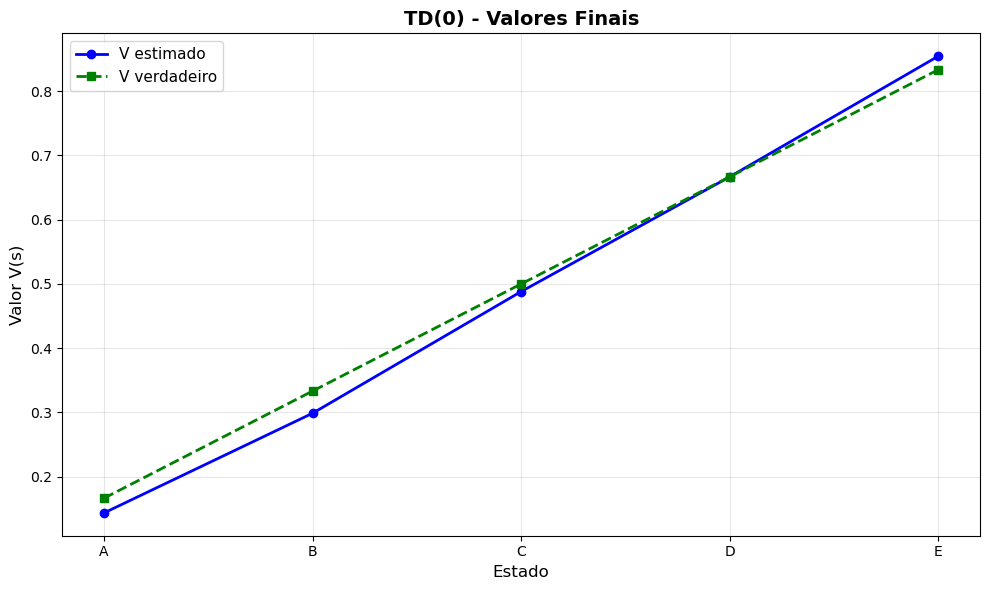

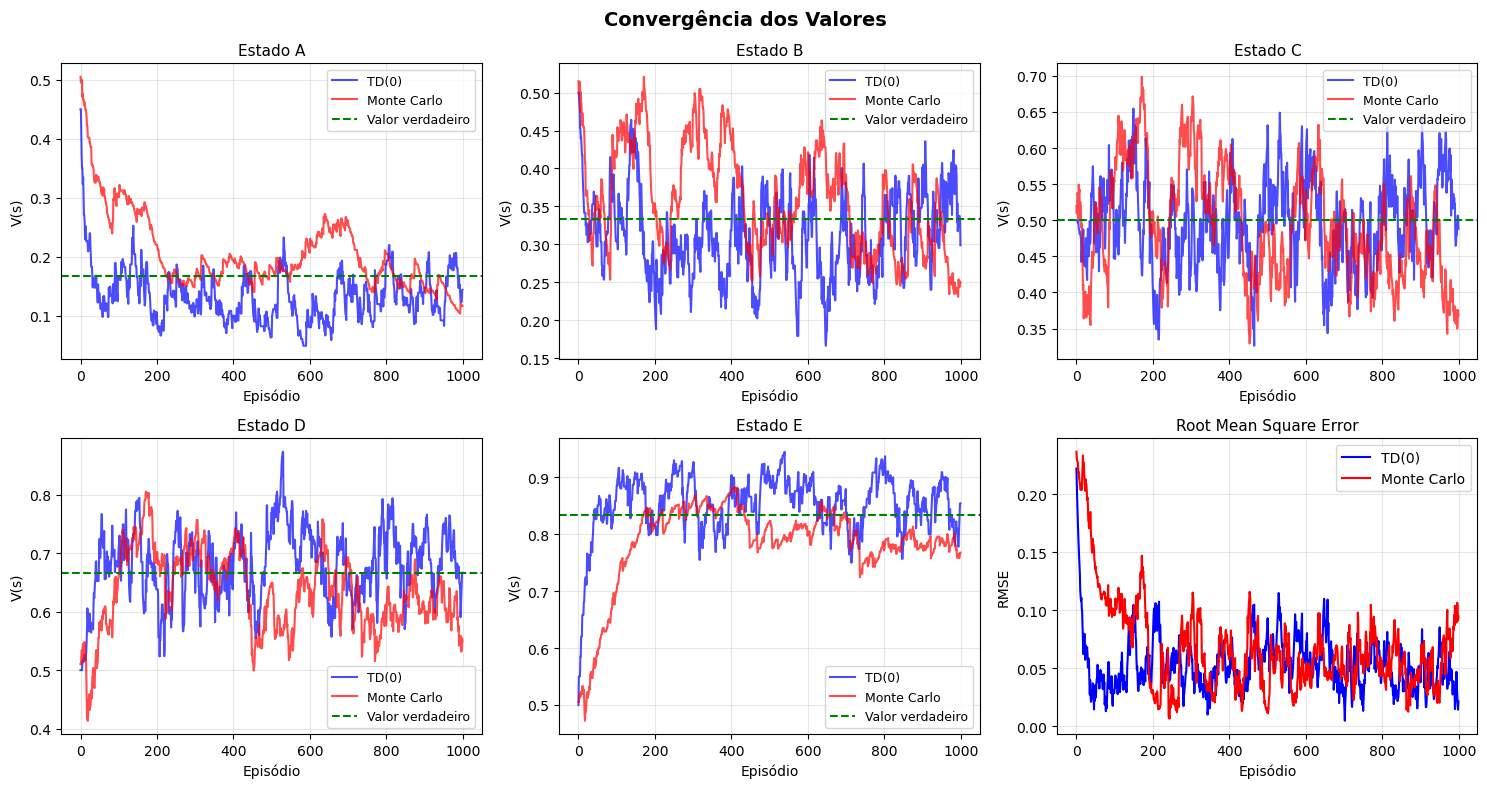

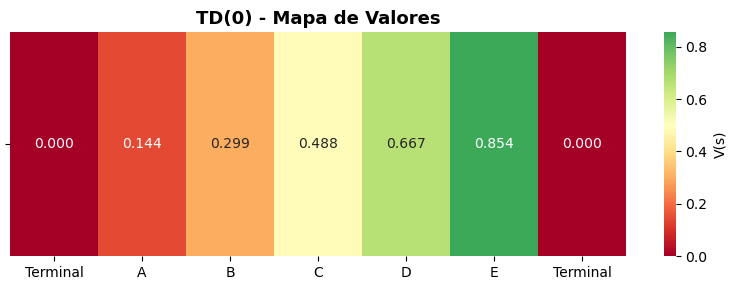


4. Análise de sensibilidade...


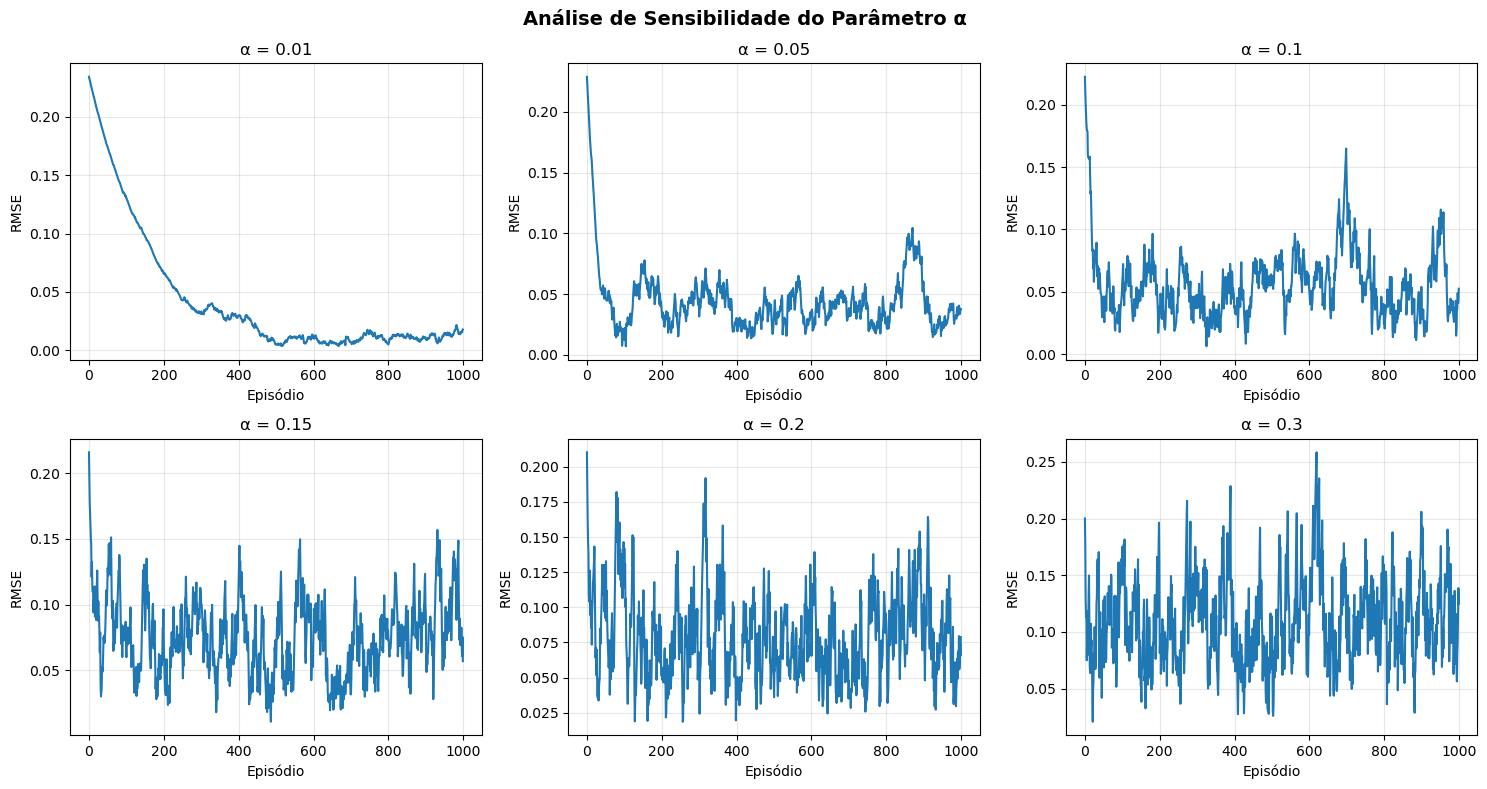


5. Tabela de Valores Finais:
------------------------------------------------------------
Estado     V_true          V_TD(0)         V_MC           
------------------------------------------------------------
A          0.1667          0.1437          0.1164         
B          0.3333          0.2988          0.2488         
C          0.5000          0.4881          0.3681         
D          0.6667          0.6667          0.5489         
E          0.8333          0.8543          0.7676         
------------------------------------------------------------

RMSE Final:
  TD(0):        0.0214
  Monte Carlo:  0.0951


In [ ]:
# Criar ambiente
env = LinearEnv()

# Política aleatória
def random_policy(state):
    return np.random.choice([0, 1])

# Parâmetros
episodes = 1000
gamma = 1.0
alpha_td = 0.1
alpha_mc = 0.01

# Inicializar V(s) = 0.5 para estados não-terminais
V_init = defaultdict(lambda: 0.5)
V_init[0] = V_init[6] = 0.0

print("\n1. Treinando TD(0)...")
V_td, V_history_td = td_prediction_with_history(
    env, random_policy, episodes, gamma, alpha_td, V_init.copy()
)

print("2. Treinando Monte Carlo para comparação...")
V_mc, V_history_mc = mc_prediction_with_history(
    env, random_policy, episodes, gamma, alpha_mc, V_init.copy()
)

print("\n3. Gerando visualizações...")

# Plot 1: Valores finais
plot_value_estimates(V_td, "TD(0) - Valores Finais")

# Plot 2: Convergência
plot_convergence(V_history_td, V_history_mc, LinearEnv.V_true)

# Plot 3: Heatmap
plot_heatmap_values(V_td, "TD(0) - Mapa de Valores")

# Plot 4: Sensibilidade aos parâmetros
print("\n4. Análise de sensibilidade...")
analyze_parameter_sensitivity(env, random_policy, episodes=episodes)

# Tabela de resultados
print("\n5. Tabela de Valores Finais:")
print("-" * 60)
print(f"{'Estado':<10} {'V_true':<15} {'V_TD(0)':<15} {'V_MC':<15}")
print("-" * 60)

states = ['A', 'B', 'C', 'D', 'E']
for i, state in enumerate(states, 1):
    v_true = LinearEnv.V_true[i]
    v_td = V_td.get(i, 0)
    v_mc = V_mc.get(i, 0)
    print(f"{state:<10} {v_true:<15.4f} {v_td:<15.4f} {v_mc:<15.4f}")

print("-" * 60)

# Calcular RMSE final
rmse_td = np.sqrt(np.mean([(V_td.get(i, 0) - LinearEnv.V_true[i])**2
                           for i in range(1, 6)]))
rmse_mc = np.sqrt(np.mean([(V_mc.get(i, 0) - LinearEnv.V_true[i])**2
                           for i in range(1, 6)]))

print(f"\nRMSE Final:")
print(f"  TD(0):        {rmse_td:.4f}")
print(f"  Monte Carlo:  {rmse_mc:.4f}")

#return V_td, V_mc, V_history_td, V_history_mc


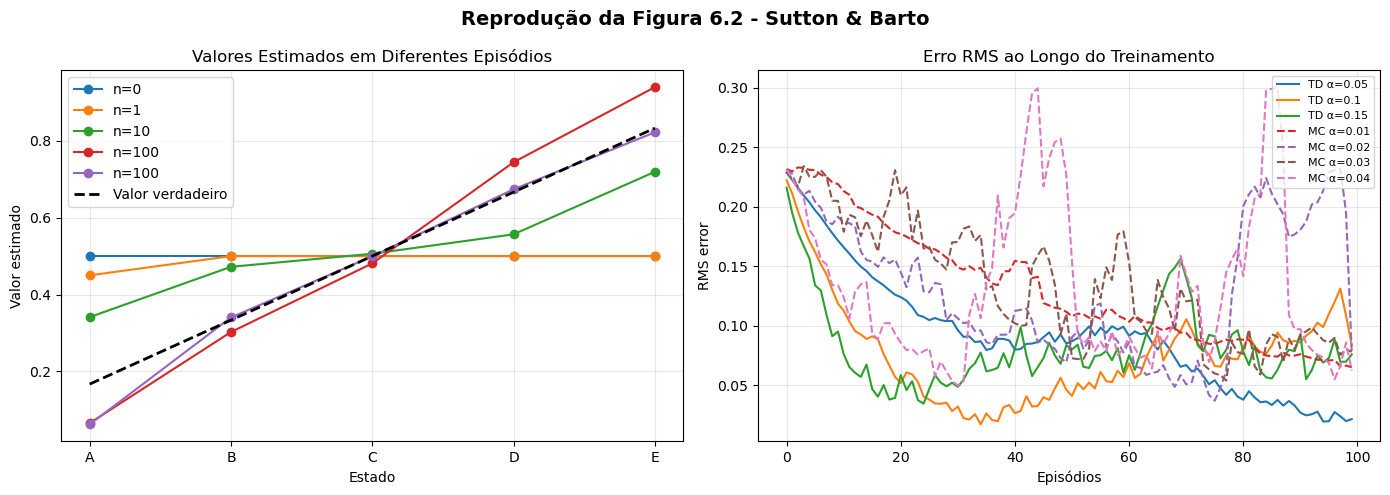

In [ ]:
def reproduce_figure_6_2():
    """
    Reproduz a Figura 6.2 de Sutton & Barto
    Mostrando valores estimados em diferentes pontos do treinamento
    """
    env = LinearEnv()

    def random_policy(state):
        return np.random.choice([0, 1])

    # Inicializar com 0.5
    V_init = defaultdict(lambda: 0.5)
    V_init[0] = V_init[6] = 0.0

    # Diferentes números de episódios
    episodes_list = [0, 1, 10, 100, 100]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfico da esquerda: Valores estimados
    ax1 = axes[0]

    for n_ep in episodes_list:
        if n_ep == 0:
            V = V_init.copy()
        else:
            V = td_prediction(env, random_policy, n_ep,
                            gamma=1.0, alpha=0.1, V_init=V_init.copy())

        states = list(range(1, 6))
        values = [V[s] for s in states]
        ax1.plot(states, values, marker='o', label=f'n={n_ep}')

    # Valor verdadeiro
    ax1.plot(range(1, 6), LinearEnv.V_true[1:6], 'k--',
            label='Valor verdadeiro', linewidth=2)

    ax1.set_xlabel('Estado')
    ax1.set_ylabel('Valor estimado')
    ax1.set_title('Valores Estimados em Diferentes Episódios')
    ax1.set_xticks(range(1, 6))
    ax1.set_xticklabels(['A', 'B', 'C', 'D', 'E'])
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Gráfico da direita: Erro RMS ao longo do tempo
    ax2 = axes[1]

    # Comparar diferentes alphas
    alphas_td = [0.05, 0.10, 0.15]
    alphas_mc = [0.01, 0.02, 0.03, 0.04]

    # TD
    for alpha in alphas_td:
        V_init_copy = V_init.copy()
        _, V_history = td_prediction_with_history(
            env, random_policy, 100, gamma=1.0,
            alpha=alpha, V_init=V_init_copy
        )

        rmse = []
        for ep_values in V_history:
            errors = [(ep_values[i] - LinearEnv.V_true[i])**2 for i in range(1, 6)]
            rmse.append(np.sqrt(np.mean(errors)))

        ax2.plot(rmse, label=f'TD α={alpha}', linestyle='-')

    # Monte Carlo
    for alpha in alphas_mc:
        V_init_copy = V_init.copy()
        _, V_history = mc_prediction_with_history(
            env, random_policy, 100, gamma=1.0,
            alpha=alpha, V_init=V_init_copy
        )

        rmse = []
        for ep_values in V_history:
            errors = [(ep_values[i] - LinearEnv.V_true[i])**2 for i in range(1, 6)]
            rmse.append(np.sqrt(np.mean(errors)))

        ax2.plot(rmse, label=f'MC α={alpha}', linestyle='--')

    ax2.set_xlabel('Episódios')
    ax2.set_ylabel('RMS error')
    ax2.set_title('Erro RMS ao Longo do Treinamento')
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)

    plt.suptitle('Reprodução da Figura 6.2 - Sutton & Barto',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Executar reprodução
reproduce_figure_6_2()

## 4. Principais Insights

### Vantagens do TD(0):
- **Aprendizado Online**: Atualiza a cada passo, não precisa esperar o fim do episódio
- **Bootstrap**: Usa estimativas para melhorar estimativas
- **Menor Variância**: Comparado com Monte Carlo

### Desvantagens:
- **Viés**: Por usar bootstrap, pode ter viés inicial
- **Sensível a α**: Escolha do step size é crítica

### Comparação TD vs MC:

| Aspecto | TD(0) | Monte Carlo |
|---------|-------|--------------|
| Atualização | Online (cada passo) | Offline (fim do episódio) |
| Variância | Menor | Maior |
| Viés | Sim (bootstrap) | Não (usa retornos reais) |
| Convergência | Mais rápida geralmente | Mais lenta |
| Episódios infinitos | Funciona | Não funciona |

## 5. Equações Resumidas

### Atualização TD(0):
$$V(S_t) \leftarrow V(S_t) + \alpha \delta_t$$

### TD Error:
$$\delta_t = R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$$

### RMSE (Root Mean Square Error):
$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{s \in \mathcal{S}} \left( V(s) - V_{\pi}(s) \right)^2}$$

### Comparação com Monte Carlo:
- **MC Update**: $V(S_t) \leftarrow V(S_t) + \alpha[G_t - V(S_t)]$
- **TD Update**: $V(S_t) \leftarrow V(S_t) + \alpha[R_{t+1} + \gamma V(S_{t+1}) - V(S_t)]$

Onde $G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ...$